In [1]:
from __future__ import division, print_function
import sys, os, glob, gc, warnings
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import matplotlib.pyplot as plt

import healpy as hp

from desiutil.plots import init_sky, plot_sky_binned

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

plt.rcParams['image.cmap'] = 'seismic'

In [3]:
field = 'south'

sweep = Table(fitsio.read('/Users/rongpu/Documents/Data/dr9_tests/sky_residuals/dr9_sky_residual_{}.fits'.format(field)))
print(len(sweep))

maskbits = [1, 5, 6, 7, 8, 9, 11, 12, 13]
mask_clean = np.ones(len(sweep), dtype=bool)
for bit in maskbits:
    mask_clean &= (sweep['MASKBITS'] & 2**bit)==0
print(np.sum(~mask_clean)/len(mask_clean))
# sweep = sweep[mask_clean]
# print(len(sweep))

17850328
0.05669234761400463


__For simplicity, here we only look at g-band__

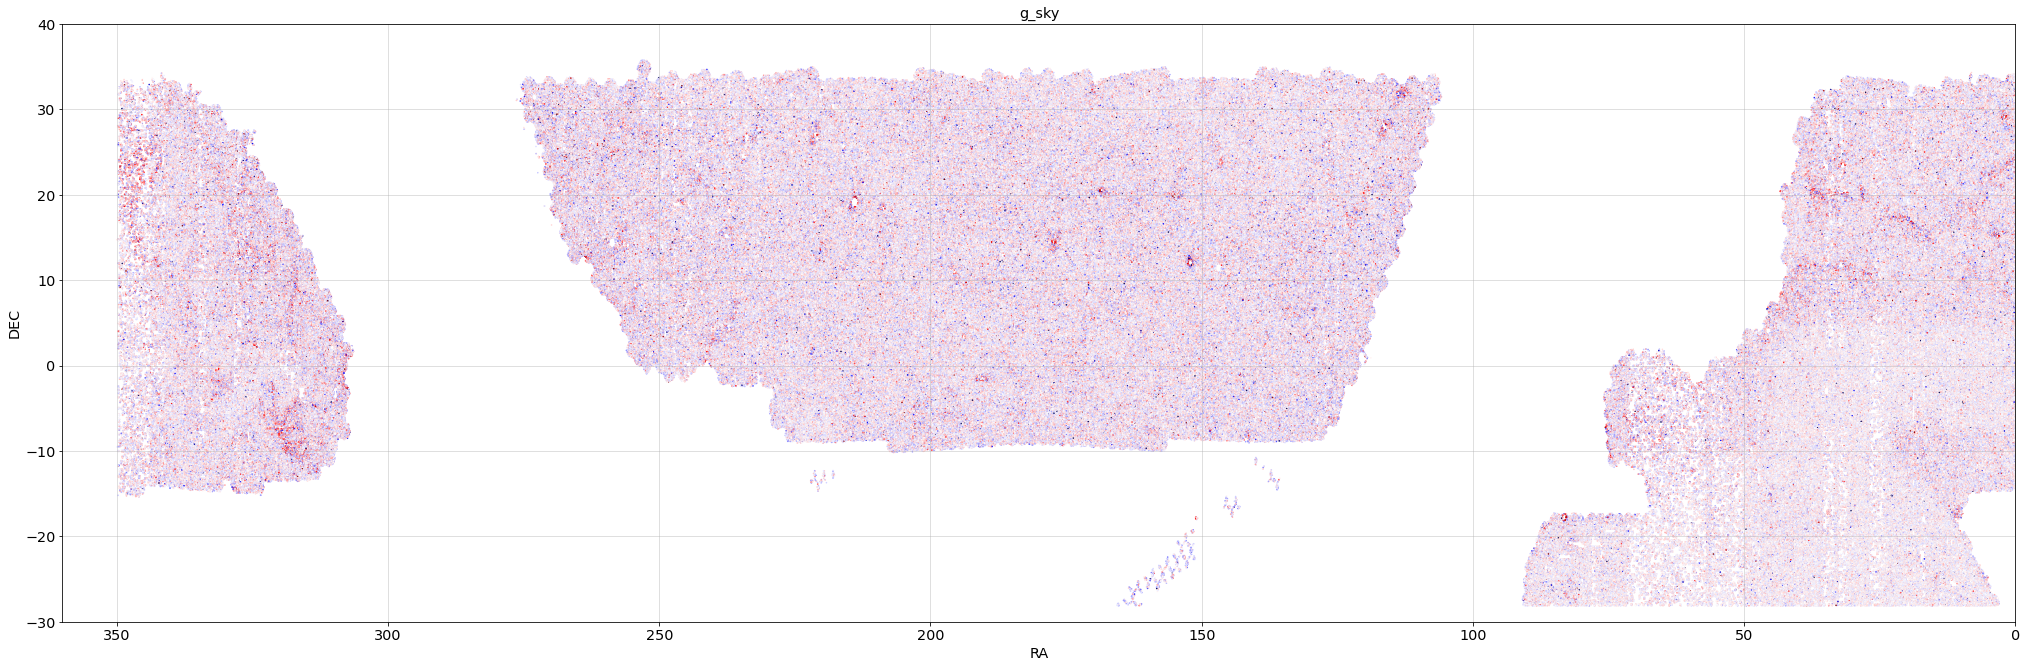

In [4]:
for col in ['g_sky']:
    fig, ax = plt.subplots(figsize=(35, 11))
    im = ax.scatter(sweep['RA'][mask_clean][::10], sweep['DEC'][mask_clean][::10], c=sweep[col][mask_clean][::10], vmin=-0.02, vmax=0.02, s=0.3, alpha=1., cmap='seismic')
    ax.axis([360, 0, -30, 40])
    ax.grid(alpha=0.5)
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    # fig.colorbar(im)
    ax.set_title(col)
    # plt.savefig('plots/{}_scatter.png'.format(col), dpi=200)
    plt.show()

sweep objects: median g_sky sky residuals per sq arcsec: 0.00006


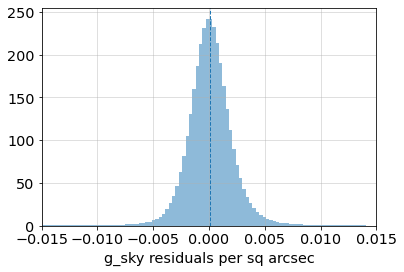

In [5]:
histrange = 0.015
for col in ['g_sky']:
    v = sweep[col][mask_clean]
    print('sweep objects: median {} sky residuals per sq arcsec: {:.5f}'.format(col, np.median(v)))
    plt.hist(v, 100, range=(-histrange, histrange), density=True, alpha=0.5)
    plt.axvline(np.median(v), color='C0', ls='--', lw=1)
    plt.xlim(-histrange, histrange)
    plt.grid(alpha=0.5)
    plt.xlabel('{} residuals per sq arcsec'.format(col))
    plt.show()
print()

In [6]:
# clip_lo_list = [-0.003, -0.004, -0.006, -0.003, -0.004, -0.006, -0.006, -0.006]
# clip_hi_list = [0.003, 0.004, 0.006, 0.003, 0.004, 0.006, 0.006, 0.006]
# col_list = ['g_sky', 'r_sky', 'z_sky', 'g_blobsky', 'r_blobsky', 'z_blobsky', 'w1_sky_7_9', 'w2_sky_7_9']
# for col, clip_lo, clip_hi in zip(col_list, clip_lo_list, clip_hi_list):
#     print(col)
#     fig, ax = plt.subplots(figsize=(35, 22))
#     im = ax.scatter(sweep['RA'][mask_clean][::4], sweep['DEC'][mask_clean][::4], c=sweep[col][mask_clean][::4], vmin=clip_lo*7, vmax=clip_hi*7, s=0.1, alpha=1., cmap='seismic')
#     ax.axis([310, 80, 30, 85])
#     ax.grid(alpha=0.5)
#     ax.set_xlabel('RA')
#     ax.set_ylabel('DEC')
#     # fig.colorbar(im)
#     ax.set_title(col)
#     plt.tight_layout()
#     plt.savefig('plots/scatter_{}.png'.format(col), dpi=200)
#     plt.close()

In [7]:
# # Downsampling sweep
# np.random.seed(123)
# idx = np.sort(np.random.choice(len(sweep), size=len(sweep)//2, replace=False))

# print(len(sweep))
# sweep = sweep[idx]
# print(len(sweep))

In [8]:
nside = 64
npix = hp.nside2npix(nside)
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)

# Assign objects to healpix pixels
pix = hp.pixelfunc.ang2pix(nside, sweep['RA'], sweep['DEC'], lonlat=True)
pix_unique, pix_count = np.unique(pix, return_counts=True)
count = np.zeros(npix, dtype=int)
count[pix_unique] = pix_count

hp_table = Table()
hp_table['hp_idx'] = np.arange(npix)
hp_table['count'] = count

columns = ('g_sky', 'r_sky', 'z_sky', 'g_blobsky', 'r_blobsky', 'z_blobsky', 'w1_sky_5_7', 'w1_sky_7_9', 'w1_sky_9_11', 'w2_sky_5_7', 'w2_sky_7_9', 'w2_sky_9_11')
tmp = np.zeros([npix, len(columns)])
hp_table1 = Table(tmp, names=columns)
hp_table = hstack([hp_table, hp_table1])

for index in range(len(pix_unique)):

    if (index+1)%(len(pix_unique)//10)==0:
        print('{:.0f}%'.format(index/(len(pix_unique))*100))

    mask = (pix==pix_unique[index])
    
    hp_table['g_sky'][pix_unique[index]] = np.median(sweep['g_sky'][mask])
    hp_table['r_sky'][pix_unique[index]] = np.median(sweep['r_sky'][mask])
    hp_table['z_sky'][pix_unique[index]] = np.median(sweep['z_sky'][mask])
    hp_table['g_blobsky'][pix_unique[index]] = np.median(sweep['g_blobsky'][mask])
    hp_table['r_blobsky'][pix_unique[index]] = np.median(sweep['r_blobsky'][mask])
    hp_table['z_blobsky'][pix_unique[index]] = np.median(sweep['z_blobsky'][mask])
    hp_table['w1_sky_5_7'][pix_unique[index]] = np.median(sweep['w1_sky_5_7'][mask])
    hp_table['w1_sky_7_9'][pix_unique[index]] = np.median(sweep['w1_sky_7_9'][mask])
    hp_table['w1_sky_9_11'][pix_unique[index]] = np.median(sweep['w1_sky_9_11'][mask])
    hp_table['w2_sky_5_7'][pix_unique[index]] = np.median(sweep['w2_sky_5_7'][mask])
    hp_table['w2_sky_7_9'][pix_unique[index]] = np.median(sweep['w2_sky_7_9'][mask])
    hp_table['w2_sky_9_11'][pix_unique[index]] = np.median(sweep['w2_sky_9_11'][mask])
    
hp_table['ra'], hp_table['dec'] = hp.pixelfunc.pix2ang(nside, hp_table['hp_idx'], lonlat=True)
mask = hp_table['count']>0
hp_table = hp_table[mask]
hp_table.write('data/sky_residual_dr9_{}_{}.fits'.format(field, nside), overwrite=True)

10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


In [9]:
nside = 128
npix = hp.nside2npix(nside)
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)

# Assign objects to healpix pixels
pix = hp.pixelfunc.ang2pix(nside, sweep['RA'], sweep['DEC'], lonlat=True)
pix_unique, pix_count = np.unique(pix, return_counts=True)
count = np.zeros(npix, dtype=int)
count[pix_unique] = pix_count

hp_table = Table()
hp_table['hp_idx'] = np.arange(npix)
hp_table['count'] = count

columns = ('g_sky', 'r_sky', 'z_sky', 'g_blobsky', 'r_blobsky', 'z_blobsky', 'w1_sky_5_7', 'w1_sky_7_9', 'w1_sky_9_11', 'w2_sky_5_7', 'w2_sky_7_9', 'w2_sky_9_11')
tmp = np.zeros([npix, len(columns)])
hp_table1 = Table(tmp, names=columns)
hp_table = hstack([hp_table, hp_table1])

for index in range(len(pix_unique)):

    if (index+1)%(len(pix_unique)//10)==0:
        print('{:.0f}%'.format(index/(len(pix_unique))*100))

    mask = (pix==pix_unique[index])
    
    hp_table['g_sky'][pix_unique[index]] = np.median(sweep['g_sky'][mask])
    hp_table['r_sky'][pix_unique[index]] = np.median(sweep['r_sky'][mask])
    hp_table['z_sky'][pix_unique[index]] = np.median(sweep['z_sky'][mask])
    hp_table['g_blobsky'][pix_unique[index]] = np.median(sweep['g_blobsky'][mask])
    hp_table['r_blobsky'][pix_unique[index]] = np.median(sweep['r_blobsky'][mask])
    hp_table['z_blobsky'][pix_unique[index]] = np.median(sweep['z_blobsky'][mask])
    hp_table['w1_sky_5_7'][pix_unique[index]] = np.median(sweep['w1_sky_5_7'][mask])
    hp_table['w1_sky_7_9'][pix_unique[index]] = np.median(sweep['w1_sky_7_9'][mask])
    hp_table['w1_sky_9_11'][pix_unique[index]] = np.median(sweep['w1_sky_9_11'][mask])
    hp_table['w2_sky_5_7'][pix_unique[index]] = np.median(sweep['w2_sky_5_7'][mask])
    hp_table['w2_sky_7_9'][pix_unique[index]] = np.median(sweep['w2_sky_7_9'][mask])
    hp_table['w2_sky_9_11'][pix_unique[index]] = np.median(sweep['w2_sky_9_11'][mask])
    
hp_table['ra'], hp_table['dec'] = hp.pixelfunc.pix2ang(nside, hp_table['hp_idx'], lonlat=True)
mask = hp_table['count']>0
hp_table = hp_table[mask]
hp_table.write('data/sky_residual_dr9_{}_{}.fits'.format(field, nside), overwrite=True)

10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


In [10]:
nside = 256
npix = hp.nside2npix(nside)
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)

# Assign objects to healpix pixels
pix = hp.pixelfunc.ang2pix(nside, sweep['RA'], sweep['DEC'], lonlat=True)
pix_unique, pix_count = np.unique(pix, return_counts=True)
count = np.zeros(npix, dtype=int)
count[pix_unique] = pix_count

hp_table = Table()
hp_table['hp_idx'] = np.arange(npix)
hp_table['count'] = count

columns = ('g_sky', 'r_sky', 'z_sky', 'g_blobsky', 'r_blobsky', 'z_blobsky', 'w1_sky_5_7', 'w1_sky_7_9', 'w1_sky_9_11', 'w2_sky_5_7', 'w2_sky_7_9', 'w2_sky_9_11')
tmp = np.zeros([npix, len(columns)])
hp_table1 = Table(tmp, names=columns)
hp_table = hstack([hp_table, hp_table1])

for index in range(len(pix_unique)):

    if (index+1)%(len(pix_unique)//10)==0:
        print('{:.0f}%'.format(index/(len(pix_unique))*100))

    mask = (pix==pix_unique[index])
    
    hp_table['g_sky'][pix_unique[index]] = np.median(sweep['g_sky'][mask])
    hp_table['r_sky'][pix_unique[index]] = np.median(sweep['r_sky'][mask])
    hp_table['z_sky'][pix_unique[index]] = np.median(sweep['z_sky'][mask])
    hp_table['g_blobsky'][pix_unique[index]] = np.median(sweep['g_blobsky'][mask])
    hp_table['r_blobsky'][pix_unique[index]] = np.median(sweep['r_blobsky'][mask])
    hp_table['z_blobsky'][pix_unique[index]] = np.median(sweep['z_blobsky'][mask])
    hp_table['w1_sky_5_7'][pix_unique[index]] = np.median(sweep['w1_sky_5_7'][mask])
    hp_table['w1_sky_7_9'][pix_unique[index]] = np.median(sweep['w1_sky_7_9'][mask])
    hp_table['w1_sky_9_11'][pix_unique[index]] = np.median(sweep['w1_sky_9_11'][mask])
    hp_table['w2_sky_5_7'][pix_unique[index]] = np.median(sweep['w2_sky_5_7'][mask])
    hp_table['w2_sky_7_9'][pix_unique[index]] = np.median(sweep['w2_sky_7_9'][mask])
    hp_table['w2_sky_9_11'][pix_unique[index]] = np.median(sweep['w2_sky_9_11'][mask])
    
hp_table['ra'], hp_table['dec'] = hp.pixelfunc.pix2ang(nside, hp_table['hp_idx'], lonlat=True)
mask = hp_table['count']>0
hp_table = hp_table[mask]
hp_table.write('data/sky_residual_dr9_{}_{}.fits'.format(field, nside), overwrite=True)

10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


---------

In [4]:
field = 'south'

In [5]:
nside = 64
npix = hp.nside2npix(nside)
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)

hp_table = Table.read('data/sky_residual_dr9_{}_{}.fits'.format(field, nside))

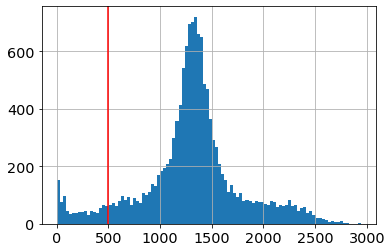

In [10]:
min_count = 500
hp_mask = hp_table['count']>min_count

plt.hist(hp_table['count'], 100)
plt.axvline(min_count, color='r')
plt.grid()
plt.show()

In [11]:
col_list = ['count', 'g_sky', 'r_sky', 'z_sky', 'w1_sky_9_11', 'w2_sky_9_11']
vrange_list = [None, 0.001, 0.002, 0.004, 0.003, 0.004]

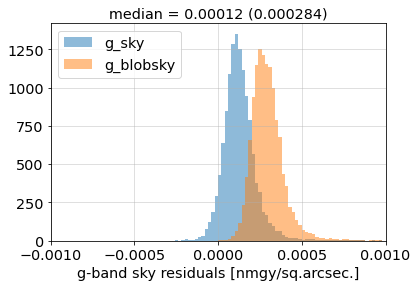

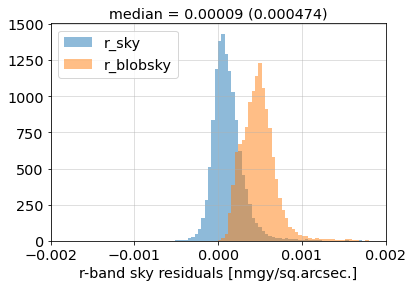

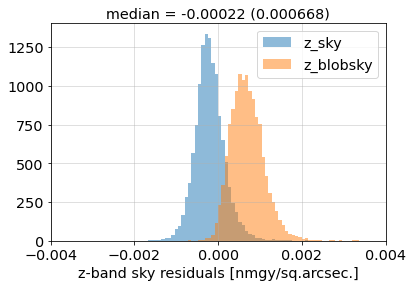

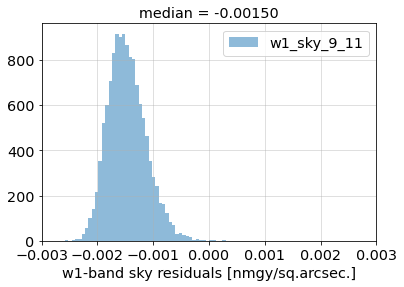

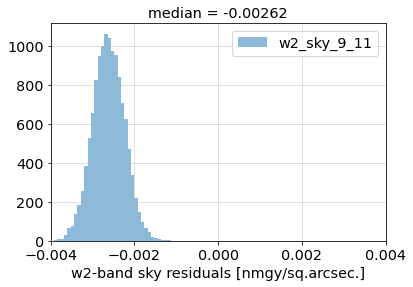

In [12]:
for col, vrange in zip(col_list, vrange_list):
    if col=='count':
        continue
    v = hp_table[col][hp_mask]
    plt.hist(v, 100, range=(-vrange, vrange), alpha=0.5, label=col)
    if col in ['g_sky', 'r_sky', 'z_sky']:
        col_blob = col.replace('sky', 'blobsky')
        v1 = hp_table[col_blob][hp_mask]
        plt.hist(v1, 100, range=(-vrange, vrange), alpha=0.5, label=col_blob)
        plt.title('median = {:.5f} ({:5f})'.format(np.median(v), np.median(v1)))
    else:
        plt.title('median = {:.5f}'.format(np.median(v)))
    plt.xlim(-vrange, vrange)
    plt.xlabel('{}-band sky residuals [nmgy/sq.arcsec.]'.format(col[:col.find('sky')-1]))
    plt.grid(alpha=0.5)
    plt.legend()
    plt.show()

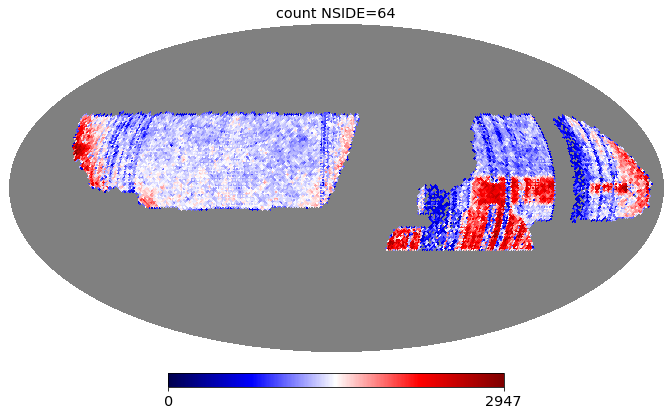

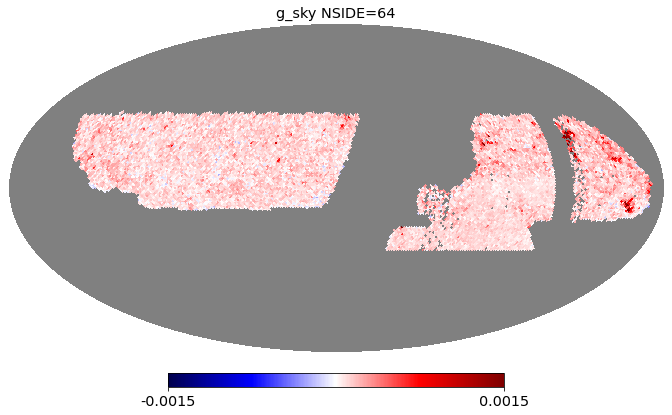

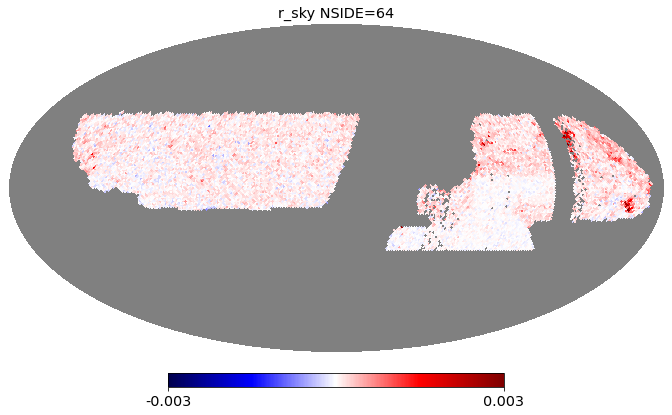

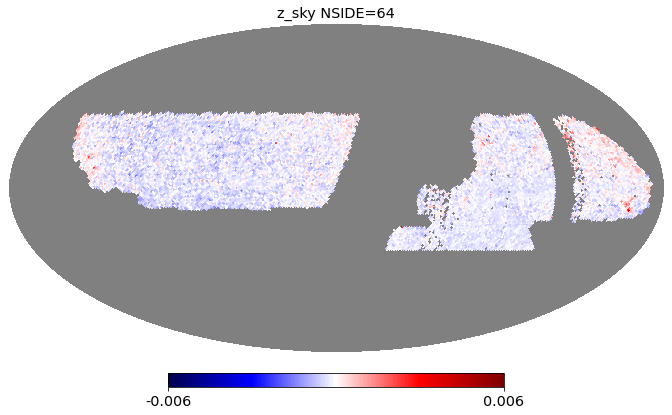

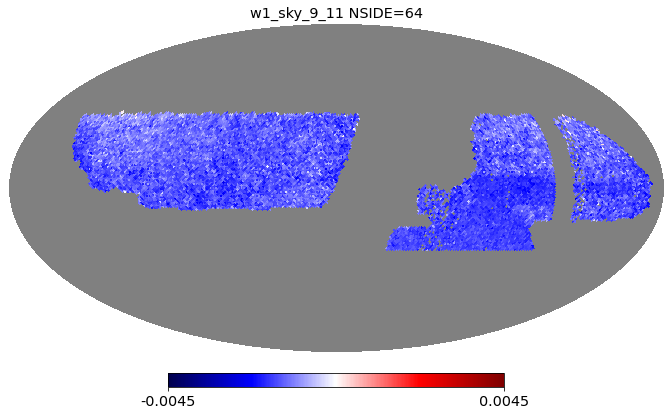

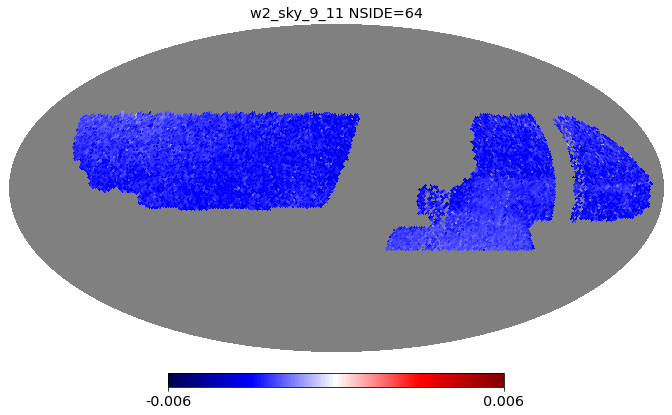

In [13]:
for col, vrange in zip(col_list, vrange_list):

    density = np.zeros(npix)  # density (per sq deg)
    mplot_mask = np.zeros(npix, dtype=bool)
    density[hp_table['hp_idx'][hp_mask]] = hp_table[col][hp_mask]
    mplot_mask[hp_table['hp_idx'][hp_mask]] = True
    mplot = hp.ma(density)
    mplot.mask = ~mplot_mask

    plt.figure(figsize=(9.7, 6))
    if col=='count':
        hp.mollview(mplot, min=0, max=None, rot=(120, 0, 0), fig=1, xsize=8000, title='{} NSIDE={}'.format(col, nside))
    else:
        hp.mollview(mplot, min=-vrange*1.5, max=vrange*1.5, rot=(120, 0, 0), fig=1, xsize=8000, title='{} NSIDE={}'.format(col, nside))
    # plt.savefig('plots/{}_{}.png'.format(col, nside), dpi=200)
    plt.show()